# Выбор региона для разработки новых нефтяных месторождений

Добывающей компании нужно решить, где бурить новую скважину. Собраны характеристики пробы нефти для скважин: качество нефти и объём её запасов по трем регионам по 10 000 месторождений в каждом. Задача - построить модель для предсказания объема запасов в новых скважинах. 

### План решения задачи

* [1. Загрузка и подготовка данных](#1-bullet)
* [2. Обучение и проверка модели](#2-bullet)
* [3. Подготовка к расчёту прибыли ](#3-bullet)
* [4. Расчёт прибыли и рисков](#4-bullet)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 1. Загрузка и подготовка данных <a id='1-bullet'></a>

Для удобства будет хранить данные в одном списке

In [2]:
import os


data = []

for df in ['geo_data_0.csv', 'geo_data_1.csv', 'geo_data_2.csv']:
    with open(os.path.join('/datasets/', df)) as f:
        data.append(pd.read_csv(f, index_col='id'))

In [3]:
for df in data:
    print(df.head())

             f0        f1        f2     product
id                                             
txEyH  0.705745 -0.497823  1.221170  105.280062
2acmU  1.334711 -0.340164  4.365080   73.037750
409Wp  1.022732  0.151990  1.419926   85.265647
iJLyR -0.032172  0.139033  2.978566  168.620776
Xdl7t  1.988431  0.155413  4.751769  154.036647
              f0         f1        f2     product
id                                               
kBEdx -15.001348  -8.276000 -0.005876    3.179103
62mP7  14.272088  -3.475083  0.999183   26.953261
vyE1P   6.263187  -5.948386  5.001160  134.766305
KcrkZ -13.081196 -11.506057  4.999415  137.945408
AHL4O  12.702195  -8.147433  5.004363  134.766305
             f0        f1        f2     product
id                                             
fwXo0 -1.146987  0.963328 -0.828965   27.758673
WJtFt  0.262778  0.269839 -2.530187   56.069697
ovLUW  0.194587  0.289035 -5.586433   62.871910
q6cA6  2.236060 -0.553760  0.930038  114.572842
WPMUX -0.515993  1.716266 

In [4]:
# признак id не несет смысловой нагрузки

for df in data:
    df.reset_index(inplace=True)
    df.drop(columns=['id'], inplace=True)
    print(df.head())

         f0        f1        f2     product
0  0.705745 -0.497823  1.221170  105.280062
1  1.334711 -0.340164  4.365080   73.037750
2  1.022732  0.151990  1.419926   85.265647
3 -0.032172  0.139033  2.978566  168.620776
4  1.988431  0.155413  4.751769  154.036647
          f0         f1        f2     product
0 -15.001348  -8.276000 -0.005876    3.179103
1  14.272088  -3.475083  0.999183   26.953261
2   6.263187  -5.948386  5.001160  134.766305
3 -13.081196 -11.506057  4.999415  137.945408
4  12.702195  -8.147433  5.004363  134.766305
         f0        f1        f2     product
0 -1.146987  0.963328 -0.828965   27.758673
1  0.262778  0.269839 -2.530187   56.069697
2  0.194587  0.289035 -5.586433   62.871910
3  2.236060 -0.553760  0.930038  114.572842
4 -0.515993  1.716266  5.899011  149.600746


In [5]:
# Разделяем выборку на фичи и таргет

features = []
target = []

for df in data:
    features.append(df.drop(columns=['product']))
    target.append(df['product'])

In [6]:
print(features[0].shape)
print(target[0].shape)

(100000, 3)
(100000,)


# 2. Обучение и проверка модели <a id='2-bullet'></a>

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
rnd_state = 222

In [8]:
# разделим данные в пропорции 75/25

splits = train_test_split(*features, *target, test_size=0.25, random_state=rnd_state)

features_train = splits[0: len(features)*2: 2]
features_valid = splits[1: len(features)*2: 2]
target_train = splits[len(features)*2: len(splits): 2]
target_valid = splits[len(features)*2+1: len(splits): 2]

In [9]:
for df in features_train:
    print('размер features_train: ', df.shape)
    
for df in target_train:
    print('размер target_train', df.shape)

размер features_train:  (75000, 3)
размер features_train:  (75000, 3)
размер features_train:  (75000, 3)
размер target_train (75000,)
размер target_train (75000,)
размер target_train (75000,)


In [10]:
# В качестве метрики будем использовать корень от квадрата ошибки (RMSE), так как его легче интерпретировать

def rmse(y_true, y_pred):
    return (mean_squared_error(y_true, y_pred))**(1/2)

In [11]:
from collections import defaultdict

model = LinearRegression()

results = defaultdict(list) # словарь для ошибок по выборкам и средних

all_pred = [] # будем складывать предсказания в общий список

for x_train, x_valid, y_train, y_valid in zip(features_train, features_valid, target_train, target_valid):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)
    all_pred.append(pd.Series(y_pred, index=y_valid.index))
    results['rmse'].append(rmse(y_valid, y_pred))
    results['mean'].append(y_pred.mean())
    
print(pd.DataFrame(results))

        rmse       mean
0  37.830422  92.539911
1   0.887138  68.219532
2  39.876607  95.058395


Регион №1 заметно выбивается: предсказывать объем запасов в месторождениях гораздо проще, чем в регионах. Между объемом запасов и f2 присутствует линейная взаимосвязь.

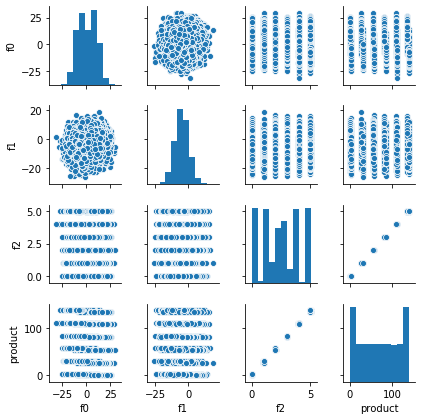

In [12]:
sns.pairplot(data[1], height=1.5)

# 3. Подготовка к расчёту прибыли <a id='3-bullet'></a>

In [13]:
# минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
# стоимость разработки делим на стоимость продукта, который равен 1000 баррелей

total_budget = 10e9
barrel_price = 450

min_product = total_budget / (barrel_price * 1000)
min_product

22222.222222222223

In [14]:
# все изучаемые месторождения региона прибыльные

for df in data:
    print(df['product'].sum())

9250000.000000002
6882500.000000002
9500000.000000004


In [15]:
# функция для подсчета прибыли по самым прибыльным скважинам

well_cost = total_budget/200

def profit(target, probs, number_wells):
    predictions_sorted = probs.sort_values(ascending=False)#.head(number_wells)
    total = (target.loc[predictions_sorted.index][:number_wells] * 1000 * barrel_price).sum()
    revenue = total - (well_cost * number_wells)
    return revenue

# 4. Расчёт прибыли и рисков <a id='4-bullet'></a>

Проводим процедуру Bootstrap и ищем среднюю прибыль, 95%-й доверительный интервал и риск убытков

,mean_profit,95_conf_interval,std,loss_wells_count
0,4.416116e+08,"(-93163335.08029445, 925181708.1086607)",2.673766e+08,0.052
1,4.498569e+08,"(24666248.955177847, 910836601.814026)",2.235164e+08,0.020
2,4.327374e+08,"(-85122591.11904041, 1002663221.0292916)",2.792139e+08,0.061


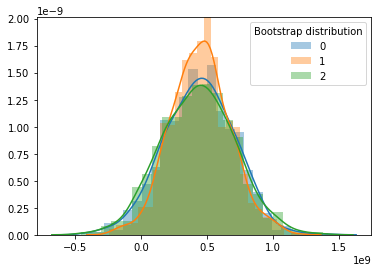

In [18]:
results = defaultdict(list)
random_state = np.random.RandomState(seed=rnd_state)
bootstrap_samp = 1000

for j, (y_valid, y_pred) in enumerate(zip(target_valid, all_pred)):
    values = []
    
    for i in range(bootstrap_samp):
        target_subsample = y_valid.sample(500, replace=True, random_state=random_state)
        probs_subsample = y_pred.loc[target_subsample.index]
        values.append(profit(target_subsample, probs_subsample, 200))
    
    values = pd.Series(values)
    lower = (1 - 0.95) / 2              # 95%-й доверительный интервал
    upper = (1 + 0.95) / 2
    results['mean_profit'].append(values.mean())
    results['95_conf_interval'].append((values.quantile(lower), values.quantile(upper)))
    results['std'].append(values.std())
    results['loss_wells_count'].append((values < 0).mean())#.sum())
    sns.distplot(values, label=j)
    plt.legend(title="Bootstrap distribution")

pd.DataFrame(results)

Предлагаю выбрать 1 регион:
- мало убыточных скважин
- узкий 95% доверительный интервал
- легче прогнозировать запасы с помощью линейной модели